# Introduction

In this notebook, we will go through the process of cleaning data and training model to predict which passengers survived during the Titanic disaster. This dataset comes from Kaggle.

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 

random_state = 142857

# Data manipulation using pandas

## Loading the csv file

We load the csv file into a `pandas.DataFrame` using `pandas.read_csv`. Dataframe is a very convinient way to manipulate data as we will see below.

In [2]:
df = pd.read_csv('data/titanic_train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Let's also look at the survivor repartition in the dataset.

In [4]:
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

## Data cleaning

Let's take a look at what percentage of each column misses values.

In [5]:
100 * df.isna().sum() / len(df)

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

We can see that the following three columns are missing values: `Age`, `Cabin` and `Embarked`. Missing values are a problem as most machine learning models are not designed to deal with them. We will see how to remedy this problem in the following sections.  

### Age

20% of age data is missing, we have to choose a way to deal with this problem.

Let's take a look at the age distribution to get an idea of the repartition.

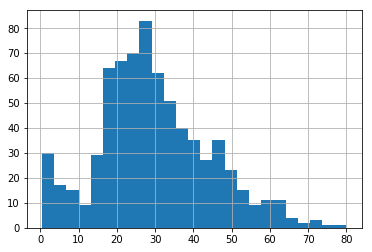

In [6]:
df['Age'].hist(bins = 25)

In [7]:
df['Age'].mean(), df['Age'].std()

(29.69911764705882, 14.526497332334044)

We suppose that the age is an important indicator of survival so instead of dropping the column altogether, we choose to fill the missing values with the average age.

In [8]:
df['Age'].fillna(df['Age'].mean(), inplace = True)

If we compute another repartition histogram, we now have a lot more values in the bin containing the mean. If this happens to be problematic during the model creation, we can always change our data cleaning strategy.

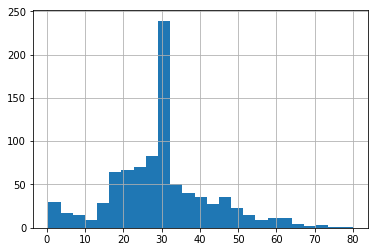

In [9]:
df['Age'].hist(bins = 25)

### Cabin

77% of the column is missing so we assume that we will not be able to use this information for the prediction and drop the column 

In [10]:
df.drop(['Cabin'], axis = 1, inplace = True)
print(df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')


In [11]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


### Embarked

0.22% of the Embarked column is missing, let's look at the value repartition to get an idea of what is happening.

In [12]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [13]:
df['Embarked'].isna().sum()

2

As only 2 values are missing, we choose to replace them with the most common value, `S`.

In [14]:
df['Embarked'].fillna('S', inplace = True)

Now that we have cleaned our dataset, let's verify that no values are missing.

In [15]:
100 * df.isna().sum() / len(df)

PassengerId    0.0
Survived       0.0
Pclass         0.0
Name           0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Embarked       0.0
dtype: float64

## Training and validation set split

In order to properly evaluate the performance of our model, we have to use data that it has not seen during its training. For this purpose, we split our data in two parts: the training set, which we will use to train the models and the validation set, which we will use to evaluate the performances. Here we choose to hold 20% of the data to build the validation set.

In [16]:
df_train, df_val = train_test_split(df, test_size = 0.2, random_state = random_state)
print(f'Training set size: {len(df_train)}')
print(f'Validation set size: {len(df_val)}')

Training set size: 712
Validation set size: 179


# Model creation

## Very simple model

### Feature selection

When we do feature selection, we choose what values our model will be allowed to use to make its predictions. 

We are building a very simple model in order to have a very rough baseline so let's select a very small amount of features.

In [17]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


For this model, we only select the `Age`, `Fare` and `Pclass` columns.

In [18]:
X_train = df_train[['Age', 'Fare', 'Pclass']]
y_train = df_train['Survived']
X_val = df_val[['Age', 'Fare', 'Pclass']]
y_val = df_val['Survived']

In [19]:
X_train.head()

,Age,Fare,Pclass
245,44.0,90.0000,1
34,28.0,82.1708,1
439,31.0,10.5000,2
822,38.0,0.0000,1
484,25.0,91.0792,1


In [20]:
y_train.head()

245    0
34     0
439    0
822    0
484    1
Name: Survived, dtype: int64

### Model training

Now let's build the model. We choose to use a `LogisticRegression` classifier, it's a very simple yet quite powerful model.

In [21]:
lr = LogisticRegression(random_state = random_state)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=142857, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

### Model evaluation

Let's take a look at the accuracy of the model, both on training and validation data.

In [22]:
print(f'The training set accuracy is {100 * lr.score(X_train, y_train):5.2f}%')
print(f'The validation set accuracy is {100 * lr.score(X_val, y_val):5.2f}%')

The training set accuracy is 69.80%
The validation set accuracy is 74.30%


We see that the model is correct 74.30% of the time on data that it has never seen, not so bad for a very simple model!

Let's try it on a few imaginary individuals.

In [47]:
individuals = [
    [42, 100, 1],
    [20, 100, 1],
    [42, 200, 1],
    [42, 100, 3]
]
survival_proba = lr.predict_proba(individuals)

for individual, prediction in zip(individuals, survival_proba):
    print(f'Individual {individual}: {100 * prediction[1]:5.2f}% of survival')

Individual [42, 100, 1]: 63.67% of survival
Individual [20, 100, 1]: 76.15% of survival
Individual [42, 200, 1]: 73.84% of survival
Individual [42, 100, 3]: 25.63% of survival


As we can see, paying more, being younger and being in first class helps a lot to survive (according to the model at least).

Now that we have a baseline model, let's move on and try to build a more powerful one.

## More complicated model

### Feature selection

As in the previous section, we have to choose what feature the model will use to make its decision.

In [25]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [26]:
X_train = df_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
X_val   = df_val[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
y_train = df_train['Survived']
y_val   = df_val['Survived']

Now that we have selected on what columns our model will learn, we have to process them in a way the algorithm will be able to work with.

### Feature engineering

#### One-hot encoding categorical values

Machine learning models work with nuerical data so we have to format all our inputs to be numerical. 

An additional constraint is that we cannot simply build a mapping for categorical values such as the following one (for the `Embarked` column): `S -> 0`, `C -> 1` and `Q -> 2`. We forbid ourselves to build such mapping because it allows the model to use the values in a way that does not make sense. For example, in the case of the `Embarked` column, if we use the mapping previously described, the model will "consider" the values `C` and `Q` to be closer (`1` and `2`) than the values `S` and `Q` (`0` and `2`) which does not make sense.

To deal with this problem, we will build what is called a *one-hot encoding* of our categorical variables. To build this one-hot encoding, we create a new `DataFrame` with as many columns as the number of possible values and for each sample, put a `1` in the column corresponding to this value and `0` elsewere.

In [27]:
embarked_dummies_train = pd.get_dummies(X_train['Embarked'], prefix = 'Embarked')
embarked_dummies_val = pd.get_dummies(X_val['Embarked'], prefix = 'Embarked')
print('Original values')
print(df_train['Embarked'].iloc[:5])
print('\n\nOne-hot encoded values')
embarked_dummies_train.head()

Original values
245    Q
34     C
439    S
822    S
484    C
Name: Embarked, dtype: object


One-hot encoded values


,Embarked_C,Embarked_Q,Embarked_S
245,0,1,0
34,1,0,0
439,0,0,1
822,0,0,1
484,1,0,0


We do the same thing for all of our categorical features.

In [28]:
sex_dummies_train    = pd.get_dummies(X_train['Sex']   , prefix = 'Sex')
sex_dummies_val      = pd.get_dummies(X_val['Sex']     , prefix = 'Sex')
pclass_dummies_train = pd.get_dummies(X_train['Pclass'], prefix = 'Pclass')
pclass_dummies_val   = pd.get_dummies(X_val['Pclass']  , prefix = 'Pclass')

Now that we have all of our one-hot encoded features, we can append them to the list of features and drop the original columns.

In [29]:
X_train = pd.concat([X_train, embarked_dummies_train, sex_dummies_train, pclass_dummies_train], axis = 1)
X_val   = pd.concat([X_val, embarked_dummies_val, sex_dummies_val, pclass_dummies_val], axis = 1)
to_drop = ['Pclass', 'Sex', 'Embarked']
X_train.drop(to_drop, axis = 1, inplace = True)
X_val.drop(to_drop, axis = 1, inplace = True)
X_train.head()

,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
245,44.0,2,0,90.0000,0,1,0,0,1,1,0,0
34,28.0,1,0,82.1708,1,0,0,0,1,1,0,0
439,31.0,0,0,10.5000,0,0,1,0,1,0,1,0
822,38.0,0,0,0.0000,0,0,1,0,1,1,0,0
484,25.0,1,0,91.0792,1,0,0,0,1,1,0,0


#### Feature scaling

Machine learning models work often best with standardized features (between 0 and 1). We will use `sklearn.preprocessing.MixMaxScaler` to rescale the values of the features `Age` and `Fare`. It is important to notice that the `MinMaxScaler` is `fit` using the training part of our dataset only, we do not want any data leak from the validation set to the training set. 

In [30]:
scaler = MinMaxScaler()
scaler.fit(X_train[['Age', 'Fare']])
scaler.data_max_

array([ 80.    , 512.3292])

In [31]:
X_train[['Age', 'Fare']] = scaler.transform(X_train[['Age', 'Fare']])
X_val[['Age', 'Fare']]   = scaler.transform(X_val[['Age', 'Fare']])
X_train.head()

,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
245,0.546199,2,0,0.175668,0,1,0,0,1,1,0,0
34,0.344510,1,0,0.160387,1,0,0,0,1,1,0,0
439,0.382327,0,0,0.020495,0,0,1,0,1,0,1,0
822,0.470566,0,0,0.000000,0,0,1,0,1,1,0,0
484,0.306694,1,0,0.177775,1,0,0,0,1,1,0,0


Let's verify that we have just changed the scale of the value and left their distribution untouched.

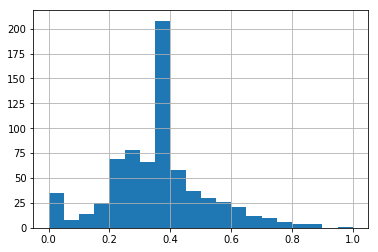

In [36]:
X_train.Age.hist(bins = 20)

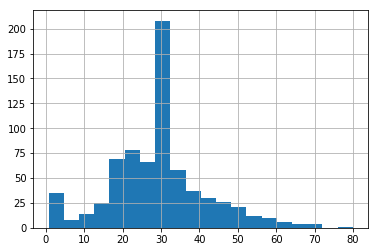

In [38]:
df_train.Age.hist(bins = 20)

### Model training

We are now going to build our model. Let's try a `RandomForestClassifier`.

In [45]:
rf = RandomForestClassifier(n_estimators=150, random_state = random_state)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=142857, verbose=0,
            warm_start=False)

### Model evaluation

Let's take a look at the accuracy of this model, both on training and validation data.

In [46]:
print(f'The training set accuracy is {100 * rf.score(X_train, y_train):5.2f}%')
print(f'The validation set accuracy is {100 * rf.score(X_val, y_val):5.2f}%')

The training set accuracy is 98.31%
The validation set accuracy is 86.03%


The validation accuracy is 86.03%, which is quite a lot better that our simple baseline.

A fun thing we can do with `RandomForestClassifier` is to ask the model the order of importance of its feature for the prediction. Let's do it on our example.

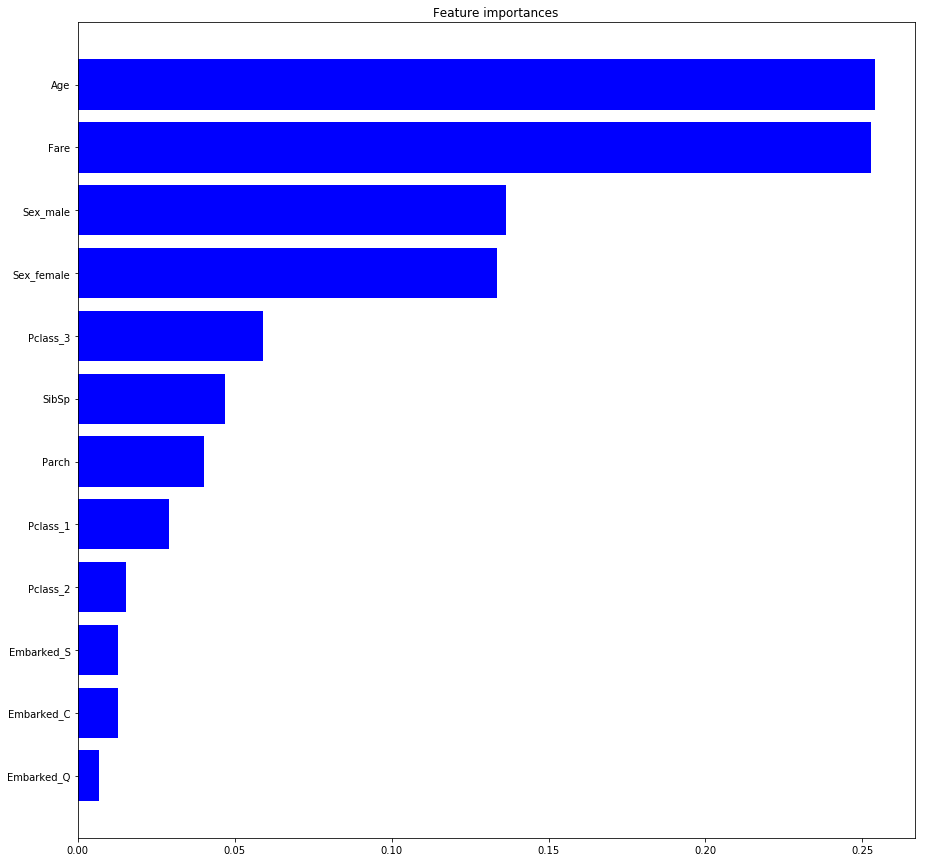

In [63]:
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (15, 15))
plt.title('Feature importances')
plt.barh(
    range(len(indices)), 
    importances[indices], 
    color = 'b', 
    align = 'center'
)
_ = plt.yticks(
    range(len(indices)),
    [X_train.columns[i] for i in indices]
)

We can see that the most important attribute to survive during Titanic sinking was being young, closely followed by the price you paid your ticket.